In [13]:
import torch
from reasoning_from_scratch.ch02 import get_device
from reasoning_from_scratch.ch03 import (
load_model_and_tokenizer
)
from reasoning_from_scratch.ch03 import render_prompt
from reasoning_from_scratch.ch04 import (
generate_text_stream_concat_flex,
generate_text_top_p_stream_cache
)
from reasoning_from_scratch.ch03 import extract_final_candidate
import math

In [4]:
device = torch.device("cpu")

model, tokenizer = load_model_and_tokenizer('base', device, use_compile=False, local_dir='../models/qwen3_base')

✓ ..\models\qwen3_base\qwen3-0.6B-base.pth already up-to-date


d:\PersonalStudy\OTHER_COURSES\BOOKS\General_Theory\LLM\LLM_second_course\REASONING_MODELS\Reasoning-Model\venv\Lib\site-packages\reasoning_from_scratch\ch03.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues re

In [10]:
raw_prompt = (
"Half the value of $3x-9$ is $x+37$. "
"What is the value of $x$?"
)

prompt = render_prompt(raw_prompt)
prompt_cot = prompt + '\n\nExplain step by step.\n'

torch.manual_seed(0)
response_1 = generate_text_stream_concat_flex(
    model, tokenizer, prompt_cot, device,
    max_new_tokens=2048, verbose=True,
    generate_func=generate_text_top_p_stream_cache,
    temperature=0.9,
    top_p=0.9
)

To solve the problem, we'll follow these steps:

1. **Understand the problem**: We are given that half the value of \( 3x - 9 \) is equal to \( x + 37 \). We need to find the value of \( x \).

2. **Translate the problem into an equation**:
   - Half the value of \( 3x - 9 \) is \( \frac{1}{2}(3x - 9) \).
   - This is equal to \( x + 37 \).

   So, the equation becomes:
   \[
   \frac{1}{2}(3x - 9) = x + 37
   \]

3. **Simplify the equation**:
   - Distribute the \( \frac{1}{2} \) on the left side:
     \[
     \frac{1}{2} \cdot 3x - \frac{1}{2} \cdot 9 = x + 37
     \]
     \[
     \frac{3x}{2} - \frac{9}{2} = x + 37
     \]

4. **Eliminate the fraction**:
   - Multiply every term by 2 to eliminate the denominator:
     \[
     2 \cdot \frac{3x}{2} - 2 \cdot \frac{9}{2} = 2 \cdot x + 2 \cdot 37
     \]
     \[
     3x - 9 = 2x + 74
     \]

5. **Isolate \( x \)**:
   - Subtract \( 2x \) from both sides to get all \( x \)-terms on one side:
     \[
     3x - 2x - 9 = 74
     \]
     \[

In [11]:
torch.manual_seed(3)
response_2 = generate_text_stream_concat_flex(
    model, tokenizer, prompt_cot, device,
    max_new_tokens=2048, verbose=True,
    generate_func=generate_text_top_p_stream_cache,
    temperature=0.9,
    top_p=0.9
)

We are given the equation:

\[
\frac{1}{2}(3x - 9) = x + 37
\]

**Step 1: Multiply both sides by 2 to eliminate the fraction.**

\[
2 \cdot \frac{1}{2}(3x - 9) = 2(x + 37)
\]

Simplifying:

\[
3x - 9 = 2x + 74
\]

**Step 2: Subtract \(2x\) from both sides to get all \(x\)-terms on one side.**

\[
3x - 2x - 9 = 74
\]

Simplifying:

\[
x - 9 = 74
\]

**Step 3: Add 9 to both sides to solve for \(x\).**

\[
x = 74 + 9
\]

Simplifying:

\[
x = 83
\]

**Final Answer:**

\[
\boxed{83}
\]

In [12]:
#Different answers, same result.
#We can demsntrate the second answer is the shortest

print(f'response_1 characters --> {len(response_1)}')
print(f'response_1 tokens --> {len(tokenizer.encode(response_1))}\n')
print(f'response_2 characters --> {len(response_2)}')
print(f'response_2 tokens --> {len(tokenizer.encode(response_2))}')

response_1 characters --> 1204
response_1 tokens --> 482

response_2 characters --> 485
response_2 tokens --> 220


If two responses are comparable, then the one that is shorter is preferable, because wastes less tokens. But overall is not alqays the case that shorter answers are the best ones, it depends on human preference, and evaluating an answer is an open field of research (reward models not always pay off)

# Rule-based score (heuristic)
We give a score based on form and preference, not correctness

In [14]:
def heuristic_score(
    answer,
    prompt=None, #A
    brevity_bonus=500.0,
    boxed_bonus=2.0,
    extract_bonus=1.0,
    fulltext_bonus=0.0,):
    score = 0.0

    cand = extract_final_candidate(answer, fallback='none') #if the returned form is 'boxed' --> bonus score

    if cand:
        score += boxed_bonus
    else:
        cand = extract_final_candidate(answer, fallback='number_only') #if the returned form is just a number
        if cand:
            score += extract_bonus
        else:
            cand = extract_final_candidate(answer, fallback='number_then_full') #if it's not a number
            if cand:
                score += fulltext_bonus
    
    score += 1.5 * math.exp(-len(answer) / brevity_bonus) #we give a reward for brevity
    return score



We can see the berivity_bonus effect with the following graphic

In [15]:
import matplotlib.pyplot as plt
def plot_brevity_curve(brevity_bonus, max_len=2048):
    lengths = torch.arange(1, max_len)
    scores = 1.5 * torch.exp(-lengths / brevity_bonus)
    plt.figure(figsize=(4, 3))
    plt.plot(lengths, scores)
    plt.xlabel("Text length (number of characters)")
    plt.ylabel("Score contribution")
    plt.tight_layout()
    #plt.savefig("brevity_curve.pdf")
    plt.show()


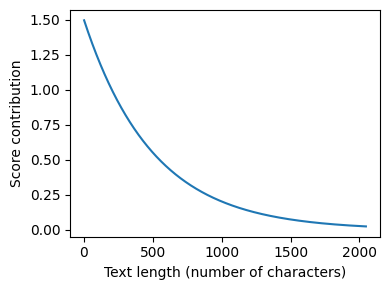

In [ ]:
plot_brevity_curve(500) #we can see that 500 is not that high, with 500 it will increase by nearly 0.4

Let's evaluate our 2 responses

In [17]:
print(round(heuristic_score(response_1), 3)) #n_digits = 3

2.135


In [18]:
print(round(heuristic_score(response_2), 3)) #n_digits = 3

2.569


We can use this function as a tie-breaker in the self-consistency loop to pick the best answer (preferable answer) among the one that are tied, or even as the only metric to pick the best answer instead of the majority voting --> in this case instead of Self Consistency we would call the method Best-of-N

In [30]:
@torch.inference_mode()
def calc_next_token_probas(model, tokenizer, prompt, device):
    model.eval()

    token_ids = torch.tensor(tokenizer.encode(prompt), device=device).unsqueeze(0)
    logits = model(token_ids).squeeze(0)
    all_probas = torch.softmax(logits, dim=-1)

    t_idxs = torch.arange(0, token_ids.shape[1] - 1, device=device)
    next_idxs = token_ids.squeeze(0)[1:]

    next_token_probas = all_probas[t_idxs, next_idxs]

    print(
        "Next-token probabilities:",
        [p.item() for p in next_token_probas]
        )
    print(
        "Joint probability:",
        torch.prod(next_token_probas) 
    )



In [31]:
calc_next_token_probas(
    model, tokenizer, device=device,
    prompt="The capital of Germany is Berlin"
)

Next-token probabilities: [5.745887756347656e-05, 0.453125, 0.016357421875, 0.7421875, 0.162109375]
Joint probability: tensor(5.0990e-08, dtype=torch.bfloat16)


Let's try another text

In [32]:
calc_next_token_probas(
    model, tokenizer, device=device,
    prompt="The capital of Germany is Bridge"
)


Next-token probabilities: [5.745887756347656e-05, 0.453125, 0.016357421875, 0.7421875, 3.03611159324646e-07]
Joint probability: tensor(9.5479e-14, dtype=torch.bfloat16)


To handle this short numbers we can introduce log-probabilities --> more numerically stable (sums instead of prods and larger numbers, negatives, up to 0 for the highiest probability, which is 1)

In [33]:
@torch.inference_mode()
def calc_next_token_logprobas(model, tokenizer, prompt, device):
    model.eval()

    token_ids = torch.tensor(tokenizer.encode(prompt), device=device).unsqueeze(0)
    logits = model(token_ids).squeeze(0)
    all_logprobas = torch.log_softmax(logits, dim=-1)

    t_idxs = torch.arange(0, token_ids.shape[1] - 1, device=device)
    next_idxs = token_ids.squeeze(0)[1:]

    next_token_logprobas = all_logprobas[t_idxs, next_idxs]

    print(
        "Next-token log-probabilities:",
        [p.item() for p in next_token_logprobas]
        )
    print(
        "Joint probability:",
        torch.sum(next_token_logprobas) 
    )


In [34]:
calc_next_token_logprobas(
    model, tokenizer, device=device,
    prompt="The capital of Germany is Berlin"
)

Next-token log-probabilities: [-9.75, -0.796875, -4.125, -0.294921875, -1.8203125]
Joint probability: tensor(-16.7500, dtype=torch.bfloat16)


In [35]:
calc_next_token_logprobas(
    model, tokenizer, device=device,
    prompt="The capital of Germany is Bridge"
)

Next-token log-probabilities: [-9.75, -0.796875, -4.125, -0.294921875, -15.0]
Joint probability: tensor(-30., dtype=torch.bfloat16)


We can use the average of log-probabilities (among the only answer, not the prompt) as a ranking value to evaluate the LLM confidence of a response

In [36]:
@torch.inference_mode()
def avg_logprob_answer(model, tokenizer, prompt, answer, device='cpu'):
    model.eval()

    prompt_ids = tokenizer.encode(prompt) 
    answer_ids = tokenizer.encode(answer) 

    token_ids = torch.tensor(prompt_ids + answer_ids, device=device).unsqueeze(0)

    start_answer = len(prompt_ids) - 1
    end_answer = token_ids.shape[1] - 1

    logits = model(token_ids).squeeze(0)
    all_logprobas = torch.log_softmax(logits, dim=-1)

    t_idxs = torch.arange(start_answer, end_answer, device=device)
    next_idxs = token_ids.squeeze(0)[start_answer + 1: end_answer + 1]

    next_token_logprobas = all_logprobas[t_idxs, next_idxs]

    return torch.mean(next_token_logprobas).item()

In [37]:
score_1 = avg_logprob_answer(
    model, tokenizer,
    prompt="What is the capital of Germany?",
    answer=" The capital of Germany is Berlin.",
    device=device
)
print(score_1)


-0.205078125


In [38]:
score_1 = avg_logprob_answer(
    model, tokenizer,
    prompt="What is the capital of Germany?",
    answer=" The capital of Germany is Bridge.",
    device=device
)
print(score_1)


-3.890625


# Self-Refinement Loop

In [40]:
raw_prompt = (
"Half the value of $3x-9$ is $x+37$. "
"What is the value of $x$?"
)
prompt = render_prompt(raw_prompt)

torch.manual_seed(123)
initial_response = generate_text_stream_concat_flex(
    model, tokenizer, prompt, device,
    max_new_tokens=2048, verbose=True,
    generate_func=generate_text_top_p_stream_cache,
    temperature=0.7,
    top_p=0.9,
)

 \boxed{12}

In [41]:
def make_critique_prompt(raw_prompt, initial_response):
    return (
        "You are a meticulous reviewer. Identify logical errors, missing "
        "steps, or arithmetic mistakes. If the answer seems correct, "
        "say so briefly. Then propose a concise plan to fix issues.\n\n"
        f"Question:\n{raw_prompt}\n\n"
        f"Draft answer:\n{initial_response}\n\n"
        "Write a short critique and bullet-point fix plan "
        "(under ~120 words).\n"
        "Critique:"
    )



In [42]:
critique_prompt = make_critique_prompt(raw_prompt, initial_response)
torch.manual_seed(123)
critique = generate_text_stream_concat_flex(
    model, tokenizer, critique_prompt, device,
    max_new_tokens=2048, verbose=True,
    generate_func=generate_text_top_p_stream_cache,
    temperature=0.7,
    top_p=0.9,
)

 The problem statement is incomplete. It is unclear what is being asked for and what the conditions are.

Fix plan: 
1. Read the problem statement carefully and identify the key information and what is being asked for.
2. Identify the conditions given in the problem statement.
3. Use the conditions to solve for the unknown variable $x$.
4. Check your answer to ensure it satisfies the conditions given in the problem statement.
5. Provide the final answer.

Solution:
Let's solve the problem step by step:

1. The problem states that half the value of $3x-9$ is $x+37$.
2. We can write this as: $\frac{1}{2}(3x-9) = x+37$.
3. To solve for $x$, we can multiply both sides of the equation by 2 to eliminate the fraction: $3x-9 = 2(x+37)$.
4. Simplify the equation: $3x-9 = 2x+74$.
5. Subtract $2x$ from both sides: $x-9 = 74$.
6. Add 9 to both sides: $x = 83$.

The value of $x$ is 83.

In [43]:
def make_refinement_prompt(raw_prompt, initial_response, critique):
    return (
        "Revise the answer using the critique. Keep it concise and "
        "end with a final boxed result: \\boxed{ANSWER}\n\n"
        f"Question:\n{raw_prompt}\n\n"
        f"Previous answer:\n{initial_response}\n\n"
        f"Critique:\n{critique}\n\n"
        "Revised answer:"
    )

In [44]:
refinement_prompt = make_refinement_prompt(raw_prompt, initial_response, critique)

torch.manual_seed(123)
final_response = generate_text_stream_concat_flex(
    model, tokenizer, refinement_prompt, device,
    max_new_tokens=2048, verbose=True,
    generate_func=generate_text_top_p_stream_cache,
    temperature=0.7,
    top_p=0.9,
)

 \boxed{83}

We can feed this process in the self-refinement function to automatize it. We can also make possible to reiterate the loop on the revised answer for a fixed number of iterations or, better, until the final response reach a target score (e.g. calculated with avergae_log_probas)

In [46]:
def self_refinement_loop(
        model,
        tokenizer,
        raw_prompt,
        device,
        iterations=2,
        max_response_tokens=2048,
        max_critique_tokens=256,
        score_fn=None,
        prompt_renderer=render_prompt,
        prompt_suffix="",
        verbose=False,
        temperature=0.7,
        top_p=0.9,
    ):

    steps = []
    prompt = prompt_renderer(raw_prompt) + prompt_suffix
    current_full = generate_text_stream_concat_flex(
        model=model,
        tokenizer=tokenizer,
        prompt=prompt,
        device=device,
        max_new_tokens=max_response_tokens,
        verbose=False,
        generate_func=generate_text_top_p_stream_cache,
        temperature=temperature,
        top_p=top_p,
    )

    current_extracted = extract_final_candidate(
        current_full, fallback="number_then_full"
    )

    if score_fn:
        current_score = score_fn(answer=current_full, prompt=prompt)
    else:
        current_score = 0.0
    
    for iter in range(iterations):

        draft_before_full = current_full
        draft_before_extracted = current_extracted
        score_before = current_score

        critique_prompt = make_critique_prompt(raw_prompt, draft_before_full)
        critique_full = generate_text_stream_concat_flex(
            model=model,
            tokenizer=tokenizer,
            prompt=critique_prompt,
            device=device,
            max_new_tokens=max_critique_tokens,
            verbose=False,
            generate_func=generate_text_top_p_stream_cache,
            temperature=temperature,
            top_p=top_p,
        )

        refinement_prompt = make_refinement_prompt(raw_prompt, draft_before_full, critique_full)
        refinement_full = generate_text_stream_concat_flex(
            model=model,
            tokenizer=tokenizer,
            prompt=refinement_prompt,
            device=device,
            max_new_tokens=max_response_tokens,
            verbose=False,
            generate_func=generate_text_top_p_stream_cache,
            temperature=temperature,
            top_p=top_p,
        )
        refinement_extracted = extract_final_candidate(
            refinement_full, fallback="number_then_full"
        )

        if score_fn:
            refinement_score = score_fn(answer=refinement_full, prompt=refinement_prompt)
        else:
            refinement_score = 0.0

        step = {
            "iteration": iter + 1,
            "draft_full": draft_before_full,
            "draft_extracted": draft_before_extracted,
            "critique": critique_full,
            "revised_full": refinement_full,
            "revised_extracted": refinement_extracted,
            "score_before": score_before,
            "score_after": refinement_score,
            }
        steps.append(step)

        if verbose:
            print(
                f"[Refinement {iter+1}/{iterations}]"
                f"\nCurrent: {draft_before_extracted}"
                f"\nRevised: {refinement_extracted}"
                f"\nScore before: {score_before:.3f}"
                f"\nScore after: {refinement_score:.3f}"
                f"\n{'=' * 25}\n"
            )



        if refinement_score > score_before:
            current_score = refinement_score
            current_full = refinement_full
            current_extracted = refinement_extracted

    return {
        "final_full": current_full,
        "final_extracted": current_extracted,
        "steps": steps,
    }
    

In [47]:
from functools import partial
avg_logprob_score = partial(
        avg_logprob_answer,
        model=model,
        tokenizer=tokenizer,
        device=device
    ) #specified fields remain fixed so that we can pass to the function only 2 parameters (prompt and answer)

In [48]:
torch.manual_seed(0)
results_logprob = self_refinement_loop(
    model=model,
    tokenizer=tokenizer,
    raw_prompt=raw_prompt,
    device=device,
    iterations=2,
    max_response_tokens=2048,
    max_critique_tokens=256,
    score_fn=avg_logprob_score,
    verbose=True,
    temperature=0.7,
    top_p=0.9,
    )


[Refinement 1/2]
Current: 38
Revised: 83
Score before: -0.941
Score after: -0.199

[Refinement 2/2]
Current: 83
Revised: 83
Score before: -0.199
Score after: -0.170



In [49]:
results_logprob['final_full']

' \\boxed{83}'

In [ ]:
results_logprob['steps'][0]['revised_full'] #longer, and bigger avg_log_probas 

' \\boxed{83}\n\nCorrected critique:\nThe solution is now correct. The equation $3x-9 = 2(x+37)$ simplifies to $3x-9 = 2x+74$, which further simplifies to $x = 83$. However, the original equation should have been $3x-9 = x+37$, leading to the correct solution $x = 38$.'